### Initial package imports

In [37]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [38]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [39]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [40]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [ ]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 
main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

### Losses indices   

In [83]:
# calculate the losses over each day per investment
main_df['SP500_Loss'] = -1 * invested_amount_SP500 * main_df['C_S&P500_Returns']
main_df['DAX40_Loss'] = -1 * invested_amount_DAX40 * main_df['C_Dax40_Returns']
main_df['NIKKEI_Loss'] = -1 * invested_amount_NIKKEI * main_df['C_Nikkei_Returns']
main_df['EU_BOND_Loss'] = -1 * main_df['Interest_Bond_Loss']

## Methods input values 

### time window

### Expected returns (daily)

In [42]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_daily_rate'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_daily_rate'].mean()
        )
    }
    return expected_returns

In [78]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head())

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss
0,2012-01-04,NaN,NaN,NaN,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000
1,2012-01-05,5189897.180583,2992352.262000,148944667.328699,1500246.523142,0.782100,0.010120,10058937.403442,58937.403442,-58937.403442
2,2012-01-06,5179533.786296,2973606.159562,148926943.509066,1500493.291886,0.786100,0.010210,10066275.054084,7337.650642,-7337.650642
3,2012-01-09,5188699.359796,2953565.582481,148926943.509066,1500738.323863,0.783300,0.010190,10036177.669230,-30097.384854,30097.384854
4,2012-01-10,5224622.209432,3024254.466714,148932706.981779,1500982.736072,0.782600,0.010190,10131650.828032,95473.158802,-95473.158802


### Portfolio variance

In [43]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [44]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [45]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

In [46]:
# Initialize lists to store results
mean_returns = []
variance_returns = []
VaR_results = []
ES_results = []  # List to store VaR results
time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

vAlpha= [.95, .99]
DF= 0

# Initialisation
vAlpha= np.array(vAlpha)

# Iterate through the DataFrame with a rolling window of 500 days
sample_size = 500

for i in range(sample_size, len(time_window)):
    # Extract the window of 500 days
    window = time_window.iloc[i - sample_size:i]
    current_date = time_window.iloc[i]['Date']
    
    # Calculate mean and variance returns using the functions
    mean_return = calculate_expected_daily_returns(window, current_date)['Portfolio_Mean_Return']
    variance_return = calculate_variance_return(window, current_date, weights)["Portfolio_Volatility"]
    
    # Append the results to the lists
    mean_returns.append(mean_return)
    variance_returns.append(variance_return)
    
    # Calculate VaR
    VaR0 = VaR(vAlpha, mean_return, variance_return, 0)
    VaR3 = VaR(vAlpha, mean_return, variance_return, 3)
    VaR4 = VaR(vAlpha, mean_return, variance_return, 4)
    VaR5 = VaR(vAlpha, mean_return, variance_return, 5)
    VaR6 = VaR(vAlpha, mean_return, variance_return, 6)

    ES0 = ES(vAlpha, mean_return, variance_return, 0)
    ES3 = ES(vAlpha, mean_return, variance_return, 3)
    ES4 = ES(vAlpha, mean_return, variance_return, 4)
    ES5 = ES(vAlpha, mean_return, variance_return, 5)
    ES6 = ES(vAlpha, mean_return, variance_return, 6)
    
    # Append VaR results to the same index
    
    VaR_results.append({
        'Date': current_date,
        'VaR Normal': VaR0,
        'VaR T3': VaR3,
        'VaR T4': VaR4,
        'VaR T5': VaR5,
        'VaR T6': VaR6
    })
    
    # Append ES results to the same index
    ES_results.append({
        'Date': current_date,
        'ES Normal': ES0,
        'ES T3': ES3,
        'ES T4': ES4,
        'ES T5': ES5,
        'ES T6': ES6
    })

# Convert the results to DataFrames for easier analysis
mean_returns_df = pd.DataFrame(mean_returns)
variance_returns_df = pd.DataFrame(variance_returns)
var_results_df = pd.DataFrame(VaR_results)
es_results_df = pd.DataFrame(ES_results)

# Display the results
display(var_results_df.head())
display(es_results_df.head())

,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6
0,2013-12-17,"[0.008602923098597772, 0.011966379949309077]","[0.007190710322248997, 0.013423453323561547]","[0.007924746219772993, 0.013561229818344591]","[0.008188329155127207, 0.013348867121458668]","[0.008315417553343406, 0.013149054070694307]"
1,2013-12-18,"[0.008592071646998692, 0.011954297901457281]","[0.007180375560421111, 0.013410838172680968]","[0.007914142894421047, 0.013548564258838092]","[0.008177629392036673, 0.013336279259615795]","[0.008304671292107196, 0.013136539314945083]"
2,2013-12-19,"[0.00862683729572483, 0.01199694272267383]","[0.007211832985331125, 0.01345689630732965]","[0.007947319858396806, 0.01359494514618309]","[0.008211423820575043, 0.013382162669991841]","[0.008338763435602388, 0.01318195464692361]"
3,2013-12-20,"[0.00864487691337611, 0.01201621656108816]","[0.007229354391390056, 0.013476704818936355]","[0.007965110618987624, 0.013614804214885687]","[0.00822931130294528, 0.01340194381218566]","[0.008356697553070615, 0.013201662467702312]"
4,2013-12-23,"[0.008656314495360792, 0.012028430943841982]","[0.007240465818463423, 0.013489255717295414]","[0.007976391573923273, 0.013627386933152618]","[0.008240653133175601, 0.01341447748463051]","[0.00836806873475983, 0.013214149992704692]"


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6
0,2013-12-17,"[0.010665231517892806, 0.013638825958681596]","[0.011524470403511797, 0.020439911959279224]","[0.011662474406968527, 0.01870402382238797]","[0.011533723621353171, 0.017506328304870897]","[0.011408485059072871, 0.016734963936047904]"
1,2013-12-18,"[0.010653625524426422, 0.01362613200888387]","[0.01151255003819533, 0.020424729679374046]","[0.011650503549786981, 0.01868947665615638]","[0.011521799870539074, 0.01749221934245198]","[0.011396607129600412, 0.016721137194612896]"
2,2013-12-19,"[0.010693222299129578, 0.013672694671527747]","[0.011554159650193794, 0.02048722444166996]","[0.011692436447439418, 0.018747904958657587]","[0.011563431158956382, 0.01754784194534342]","[0.011437945036452722, 0.016774952813444582]"
3,2013-12-20,"[0.0107120186810219, 0.013692582214140308]","[0.011573271329864599, 0.020509607643339787]","[0.01171159876769044, 0.01876965117603537]","[0.01158254623409622, 0.017569148668254306]","[0.011457014155292017, 0.016795976484138022]"
4,2013-12-23,"[0.010723932559518598, 0.013705182853476]","[0.011585383652241165, 0.020523779014535806]","[0.01172374296251871, 0.018783421638493825]","[0.011594660693532084, 0.017582642519226276]","[0.011469099690494327, 0.01680929218612174]"


## 2. var/cov multivar on t-dist

## Main method

In [47]:
def main():
    # Magic numbers
    vN = len(main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')])
    P = 50
    dMu = calculate_expected_daily_returns(window, current_date)["Portfolio_Mean_Return"]
    dSy = calculate_variance_return(window, current_date, weights)['Portfolio_Volatility']
    print(f'vN= {vN}, P= {P}, dMu= {dMu}, dSy= {dSy}')
    vAlpha= [.95, .99]
    iDF= 6

    # Initialisation
    vAlpha= np.array(vAlpha)

    # Estimation
    vVaR= VaR(vAlpha, dMu, dSy)
    vVaRt= VaR(vAlpha, dMu, dSy, df= iDF)
    print ('var, vart:', vVaR, vVaRt)

    vES= ES(vAlpha, dMu, dSy)
    vESt= ES(vAlpha, dMu, dSy, df= iDF)
    print ('es, est:', vES, vESt)

    vN= dMu+dSy*st.norm.rvs(size= 10000000)
    print (f'Simulating Norm, mean= {vN.mean()}, std= {vN.std()}')

    dVaRs= np.quantile(vN, .95)
    vI= vN >= dVaRs
    print (f'Sim, var= {dVaRs}, ES= {vN[vI].mean()}')

    dS2t= iDF/(iDF-2)
    dC= dSy / np.sqrt(dS2t)
    vT= dMu+dC*st.t.rvs(df= iDF, size= 10000000)
    print (f'Simulating t({iDF}), mean= {vT.mean()}, std= {vT.std()}')

    dVaRt= np.quantile(vT, .95)
    vI= vT >= dVaRt
    print (f'Sim, vart= {dVaRt}, ES= {vT[vI].mean()}')

    np.quantile(vT, .99)
    VaR(.95, 0, 1)


In [85]:
main()

vN= 2548, P= 50, dMu= 0.00038196164758054783, dSy= 0.009786557624963553
var, vart: [0.01647942 0.0231489 ] [0.01590931 0.02549405]
es, est: [0.02056882 0.02646523] [0.02204264 0.03260464]
Simulating Norm, mean= 0.00038227092090006116, std= 0.009785346101299242
Sim, var= 0.016484072766445104, ES= 0.020570327287195624
Simulating t(6), mean= 0.00038429518424244513, std= 0.009783019729222
Sim, vart= 0.015911871567992016, ES= 0.022032143447205135


## Historical simulation

VaR (S&P500) at 95.0% confidence level: 31.027729599999944
ES (S&P500) at 95.0% confidence level: 59.257054484375004


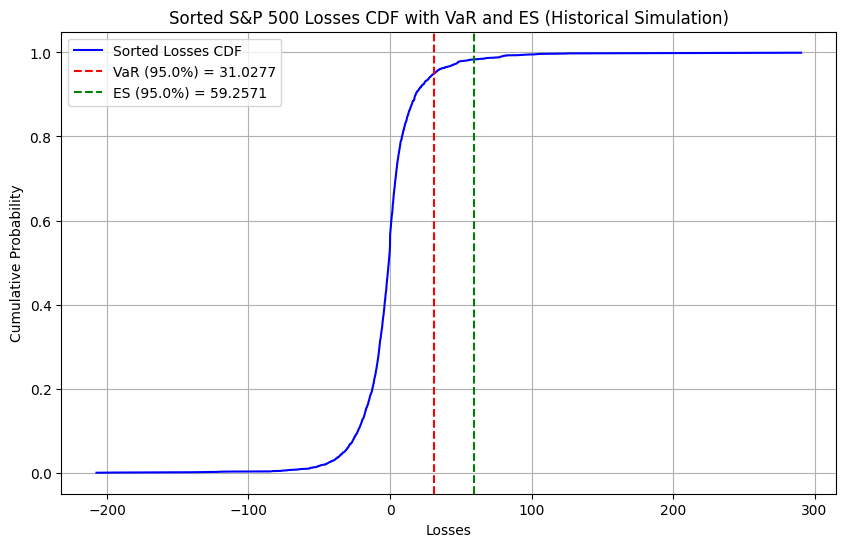

In [49]:
# Define the confidence level
confidence_level = 0.95

# Extract historical losses for S&P500 for the specified period
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# Sort the losses in ascending order (smallest loss first, largest loss last)
sorted_losses = sp500_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_sp500 = sorted_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_sp_losses = sorted_losses[sorted_losses >= VaR_sp500]
ES_sp500 = tail_sp_losses.mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses (Empirical Cumulative Distribution Function - CDF)
plt.figure(figsize=(10, 6))
# Plotting the empirical CDF: x-axis is loss value, y-axis is cumulative probability
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses CDF', color='blue')

# Highlight VaR and ES on the graph
# VaR is the loss value at the confidence level percentile
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%) = {VaR_sp500:.4f}')
# ES is the average loss in the tail beyond VaR
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%) = {ES_sp500:.4f}')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Cumulative Probability') # Changed from 'Probability' to be more precise for CDF
plt.title('Sorted S&P 500 Losses CDF with VaR and ES (Historical Simulation)')
plt.legend()
plt.grid(True) # Changed grid() to grid(True) for clarity
plt.show()

VaR (DAX40) at 95.0% confidence level: 199.3679999999997
ES (DAX40) at 95.0% confidence level: 314.866953125


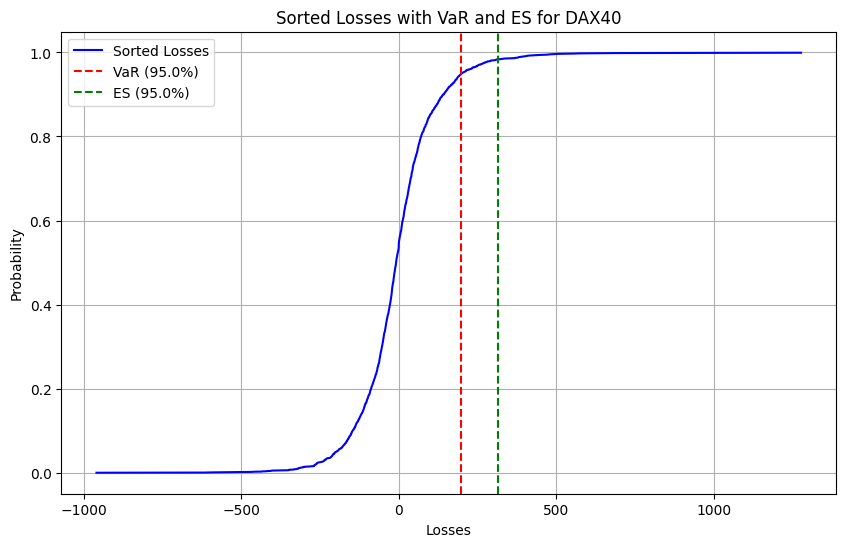

In [50]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_dax40 = sorted_dax40_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_dax_losses = sorted_dax40_losses[sorted_dax40_losses >= VaR_dax40]
ES_dax40 = tail_dax_losses.mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: 3.0092212339999986
ES (Nikkei) at 95.0% confidence level: 4.61174921890625


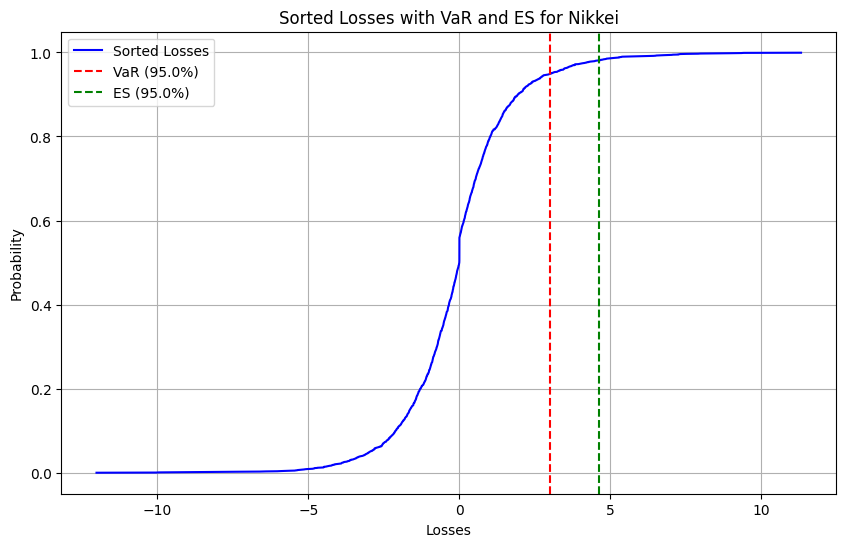

In [51]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_nikkei = sorted_nikkei_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_nik_losses = sorted_nikkei_losses[sorted_nikkei_losses >= VaR_nikkei]
ES_nikkei = tail_nik_losses.mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()

## GARCH(1,1) with constant conditional correlation 

In [135]:
from scipy.optimize import minimize

#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [147]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.02, 0.13, 0.86],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result
# result = parameter_estimation_GARCH(main_df['Portfolio_Daily_Returns'].dropna())
# Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [207]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = [0.000002, 0.13, 0.86]
    param = type('obj', (object,), {'x': param})
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)

    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [104]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [155]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [109]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns, corr_matrix):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # # Calculate the correlation matrix
    # corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [58]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [210]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.99):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

In [203]:
def count_violations(returns, VaR, ES):
    # Ensure VaR and ES are scalar values (e.g., take the first element if they are lists)
    if isinstance(VaR, list):
        VaR = VaR[0]  # Use the first value in the list
    
    # Count the number of violations for VaR
    VaR_violations = np.sum(returns < VaR)
    
    # Calculate the relative violations
    VaR_violations = VaR_violations / len(returns)

    # count the average shortfall for the VaR violations
    ES_violations = returns[returns < VaR]
    ES_violation_av = np.mean(ES_violations) if len(ES_violations) > 0 else 0

    return VaR_violations, ES_violation_av

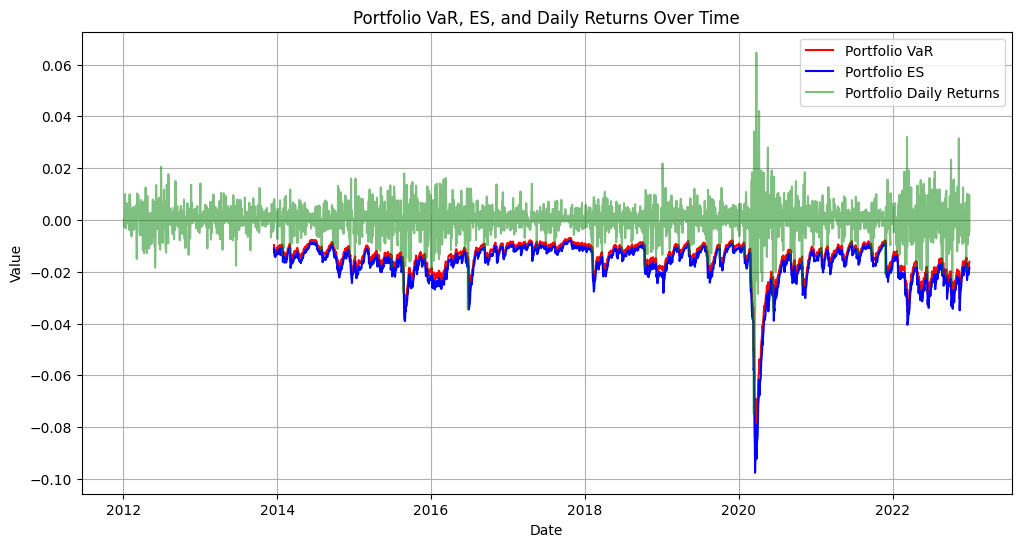

VaR Violations: 2.26%
Mean return at violation: -0.018714470810463648


,Date,Portfolio VaR,Portfolio ES,Portfolio Daily Returns
0,2013-12-17,-0.009695,-0.011107,-0.003452
1,2013-12-18,-0.010943,-0.012538,0.008041
2,2013-12-19,-0.010800,-0.012373,0.004859
3,2013-12-20,-0.012040,-0.013794,0.003492
4,2013-12-23,-0.012542,-0.014369,0.004386
...,...,...,...,...
2300,2022-12-23,-0.018109,-0.020746,0.002795
2301,2022-12-27,-0.018390,-0.021068,-0.000337
2302,2022-12-28,-0.017374,-0.019905,-0.006032
2303,2022-12-29,-0.016410,-0.018800,0.009639


In [ ]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []
    corr_matrix = correlation_matrix(main_df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna())
    # estimate the parameters per investment on the whole dataset
    
    # param = {}
    # for column in ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']:
    #     param[column] = parameter_estimation_GARCH(main_df[column].dropna())
    # estimate the parameters for the portfolio on the whole dataset
    # returns = main_df['Portfolio_Daily_Returns'].dropna()
    # param = parameter_estimation_GARCH(returns)

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns, corr_matrix)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    # Calculate daily portfolio returns
    daily_portfolio_returns = main_df['Portfolio_Daily_Returns'][time_window_size:].reset_index(drop=True)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list,
        'Portfolio Daily Returns': daily_portfolio_returns
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='green', alpha=0.5)
    plt.title('Portfolio VaR, ES, and Daily Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    portfolio_returns = main_df['Portfolio_Daily_Returns'][time_window_size:].reset_index(drop=True)
    # count the amount of violations via the method count_violations
    VaR_violations, ES_violations = count_violations(portfolio_returns, results_df['Portfolio VaR'], results_df['Portfolio ES'])
    print(f"VaR Violations: {VaR_violations:.2%}")
    print(f"Mean return at violation: {ES_violations}")
    
    return results_df

time_window_size = 500
main_analysis(time_window_size)

In [119]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))


Index(['Date', 'S&P500_Closing', 'Dax40_Closing', 'Nikkei_Closing',
       'U_S&P500_Returns', 'U_Dax40_Returns', 'U_Nikkei_Returns',
       'U_S&P500_Loss', 'U_Dax40_Loss', 'U_Nikkei_Loss', 'C_S&P500_Returns',
       'C_Dax40_Returns', 'C_Nikkei_Returns', 'C_S&P500_Loss', 'C_Dax40_Loss',
       'C_Nikkei_Loss', 'USD/EUR', 'JPY/EUR', 'TIME PERIOD',
       'Yield curve spot rate, 10-year maturity - Government bond',
       'Interest_Bond', 'Interest_Bond_Profit', 'Interest_Bond_Loss',
       'Interest_Bond_daily_rate', 'SP500_Investment', 'DAX40_Investment',
       'NIKKEI_Investment', 'EU_BOND_Investment', 'Portfolio_Daily_Returns',
       'Portfolio_Value_EUR', 'Portfolio_Change_EUR', 'Portfolio_loss',
       'SP500_Loss', 'DAX40_Loss', 'NIKKEI_Loss', 'EU_BOND_Loss'],
      dtype='object')
        Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  U_S&P500_Returns  \
0 2012-01-04     1277.300000    6111.550000     8560.110000               NaN   
1 2012-01-05     1281.060000    6095

,Start Date,End Date,Mean S&P500 Returns
0,2012-01-04,2013-12-17,0.000543
1,2012-01-05,2013-12-18,0.000566
2,2012-01-06,2013-12-19,0.000560
3,2012-01-09,2013-12-20,0.000571
4,2012-01-10,2013-12-23,0.000575


,Start Date,End Date,Mean DAX40 Returns
0,2012-01-04,2013-12-17,0.000793
1,2012-01-05,2013-12-18,0.000812
2,2012-01-06,2013-12-19,0.000851
3,2012-01-09,2013-12-20,0.000877
4,2012-01-10,2013-12-23,0.000909


,Start Date,End Date,Mean Nikkei Returns
0,2012-01-04,2013-12-17,0.000010
1,2012-01-05,2013-12-18,0.000010
2,2012-01-06,2013-12-19,0.000011
3,2012-01-09,2013-12-20,0.000011
4,2012-01-10,2013-12-23,0.000011


,Start Date,End Date,Mean EU Bond Returns
0,2012-01-04,2013-12-17,0.000137
1,2012-01-05,2013-12-18,0.000137
2,2012-01-06,2013-12-19,0.000137
3,2012-01-09,2013-12-20,0.000137
4,2012-01-10,2013-12-23,0.000137


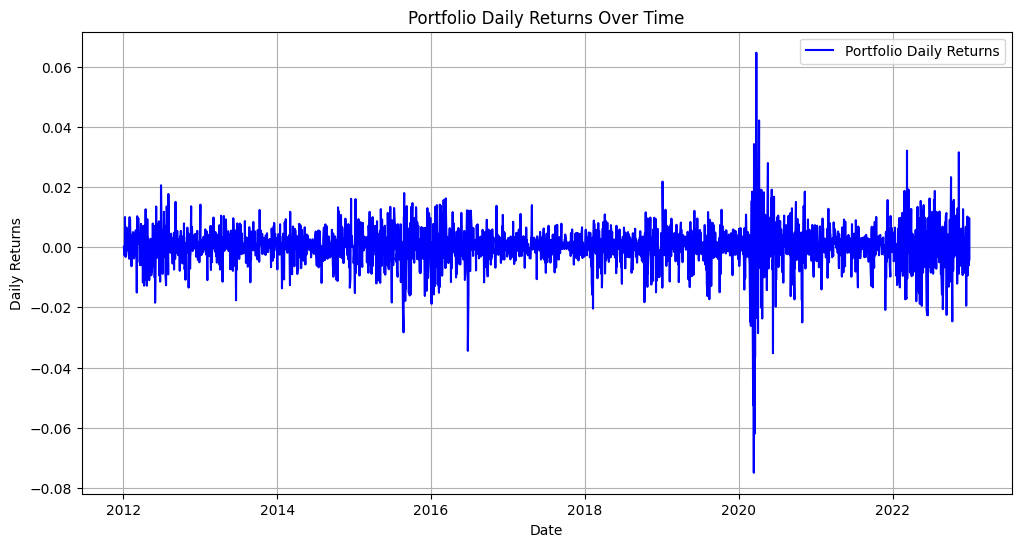

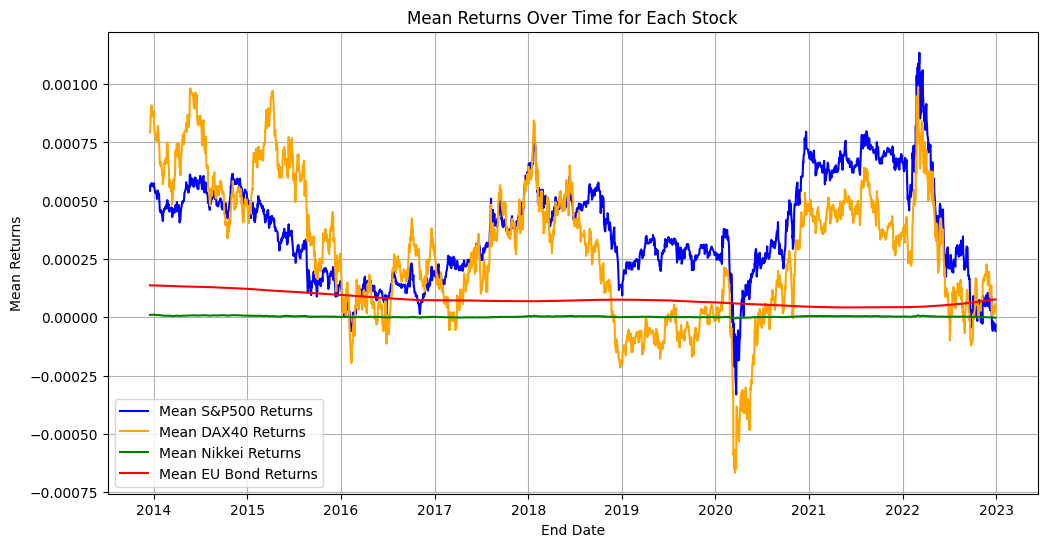

In [62]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()